In [85]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import readgadget
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm

%load_ext autoreload
%autoreload 2
import bacco
import bacco.probabilistic_bias as pb

import sys
sys.path.append('../code')
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

In [87]:
alpha = 0.5

In [88]:
save_figs = False
plot_dir = '../plots/2023-05-14_figures'
Path(plot_dir).mkdir(parents=True, exist_ok=True)
plot_tag = '_inemubounds'
tag_bpfit = ''

## Set up CAMELS-SAM params

In [89]:
tag_pbpfit = '_wsigma0'
dir_pbp = f'../data/probabilistic_bias_params/bias_params{tag_pbpfit}'
idxs_sam = [idx_sam for idx_sam in np.arange(0, 1000) \
            if os.path.isfile(f'{dir_pbp}/bias_params_LH_{idx_sam}.npy')]
if 12 in idxs_sam:
    idxs_sam.pop(12) # bad for some reason

n_sams = len(idxs_sam)
print(n_sams)
    

622


In [90]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

## Load PROVABGS data

File emailed by ChangHoon Hahn (not same as on Zenodo)

In [91]:
# probabilistic SMF
# in Mpc^-3 (no h factor!!)
fn_psmf_bgs = '../data/psmf.sv3.bgs_bright.z0.01_0.05.dat'
ms, psmf_bgs_mean, psmf_bgs_std = np.loadtxt(fn_psmf_bgs, unpack=True)

In [92]:
# Moustakas 2013, Table 3
# log M in h_70^-2 Msun
# log Phi in h_70^3 Mpc^-3 dex^-1
# From Moustakas 2013: h70 ≡ H0/(70 km s−1 Mpc−1) = 1.0

m13ksf_log_m_msun = np.array([9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 
                              10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0])
m13ksf_log_phi_Mpcn3 = np.array([-1.899, -1.923, -1.970, -2.031, -2.055, -2.106, -2.144, -2.179, -2.188, -2.216, -2.234, 
                                 -2.235, -2.262, -2.252, -2.285, -2.317, -2.365, -2.419, -2.504, -2.607, -2.728, -2.888, 
                                 -3.104, -3.332, -3.606, -3.953, -4.363, -4.778, -5.255, -5.870, -6.490])
h = 0.678 # assumed in chang paper (~Planck13)
h70 = h*100 / 70
print(f'h_70 = {h70}')
print(f'h_70^-2 = {h70**-2}')
print(f'h_70^3 = {h70**3}')

# to get from h_70^-2 Msun to just Msun, plug in that h_70^-2, but log so add instead of multiply:
m13ksf_log_m_msun += np.log10(h70**-2)

m13ksf_phi_Mpcn3 = 10**m13ksf_log_phi_Mpcn3
# to get from h_70^3 Mpc^-3 dex^-1 to just Mpc^-3 dex^-1, plug in that h_70^3:
m13ksf_phi_Mpcn3 *= h70**3

# X Mpc^-3 = X Mpc^-3 * (h^3/0.7^3) = X/0.7^3 * h^3 Mpc^-3 = X/0.7^3 * (Mpc/h)^-3
# now going from Mpc^-3 to (Mpc/h)^-3, so divide by 0.7^3
m13ksf_phi_h3Mpcn3 = h**-3 * m13ksf_phi_Mpcn3

h_70 = 0.9685714285714287
h_70^-2 = 1.0659496523698886
h_70^3 = 0.9086465072886303


## Plot CAMELS SMFs

In [93]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [94]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [95]:
smf_arr = []
ndens_arr = []
for idx_sam in idxs_sam:
    fn_dat = f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5'
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    
        
        ndens = len(log_mstar[log_mstar>edges[0]])/vol_Mpc
        #ndens = len(log_mstar)/vol_Mpc
        ndens_arr.append(ndens)

/tmp/ipykernel_23641/3454199343.py:7: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [96]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [97]:
sigma_means = []
xrange = [9.5,11]
for i, idx_sam in enumerate(idxs_sam):
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [107]:
color_mode = 'discrete'

if color_mode=='continuous':
    #vmax = np.max(sigma_means)
    vmax = 6
    locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), vmax, len(sigma_means))
    cmap = matplotlib.cm.get_cmap('cool_r')
    colors = cmap(locs_norm(sigma_means))
elif color_mode=='discrete':
    thresh = 2
    color_1sig = 'red'
    color_2sig = 'magenta'
    color_far = 'cyan'
    colors = np.full(len(sigma_means), color_far, dtype="<U10")
    i_close = sigma_means<thresh
    colors[i_close] = color_2sig
    i_1sig = sigma_means<1
    colors[i_1sig] = color_1sig
    print(np.sum(i_close))
    print(np.sum(i_1sig))

    from matplotlib.lines import Line2D
    line_1sig = Line2D([0], [0], label=r'CAMELS-SAM, $<1 \sigma$', color=color_1sig)
    line_2sig = Line2D([0], [0], label=r'CAMELS-SAM, $<2 \sigma$', color=color_2sig)
    line_far = Line2D([0], [0], label=r'CAMELS-SAM, $>2 \sigma$', color=color_far)
    handles_discrete = [line_1sig, line_2sig, line_far]

375
167


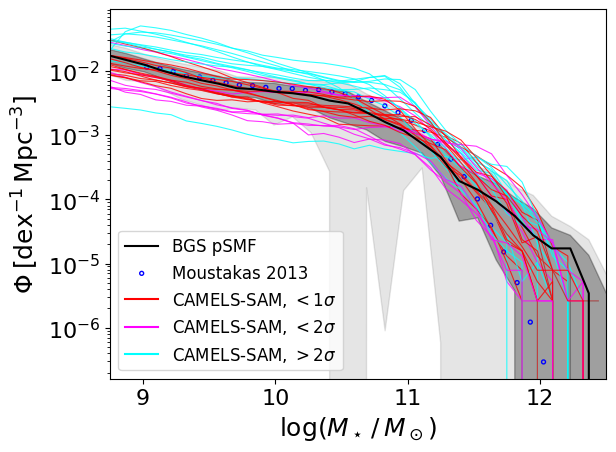

In [112]:
n_sams_plot = 30
rng = np.random.default_rng()
i_sams_plot = rng.choice(len(smf_arr), size=n_sams_plot, replace=False)
for i in i_sams_plot:
    if i==0:
        label='CAMELS-SAM SMF'
    else:
        label=None
    plt.plot(bins_avg, smf_arr[i], lw=0.8, color=colors[i], alpha=0.8, label=label)
if color_mode=='continuous':
    ax = plt.gca()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
    cb = plt.colorbar(sm, ax=ax, extend='max')
    cbar_label = r'$\bar{\sigma}_\text{SMF}$,'+'\n distance b/w SAM & BGS SMFs'
    cb.set_label(label=cbar_label, size=14)
        

plt.plot(ms, psmf_bgs_mean, color='black', label=r'BGS pSMF')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 )
plt.fill_between(ms, 
                 psmf_bgs_mean-2*psmf_bgs_std, 
                 psmf_bgs_mean+2*psmf_bgs_std,
                 color='black', alpha=0.1,
                 )


plt.scatter(m13ksf_log_m_msun, m13ksf_phi_Mpcn3, color='blue', marker='o', facecolor='None', s=8,
                 label='Moustakas 2013')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8.75, 12.5)

handles, labels = plt.gca().get_legend_handles_labels()
if color_mode=='discrete':
    handles.extend(handles_discrete)
plt.legend(handles=handles, fontsize=12)

if save_figs:
    plt.savefig(f'{plot_dir}/smfs{plot_tag}.png')

In [100]:
bias_param_names = ['b1', 'b2', 'bs2']
pbias_param_names = ["J2", "J22", "J2=2"]

# bias_to_pbias_param_name_dict = {'b1': 'J2',
#                                  'b2': 'J22',
#                                  'bs2': 'J2=2'}
pbias_to_bias_param_name_dict = {'J2': 'b1',
                                 'J22': 'b2',
                                 'J2=2': 'bs2'}
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
bounds_dict = {'b1': [-5, 20],
                'b2': [-5, 10],
                'bs2': [-10, 20],
                'bl': [-20, 30],
                'Asn': [0, 2],
                }
bias_param_names_nob1 = bias_param_names.copy()
bias_param_names_nob1.remove('b1')

In [101]:
tags_pbpfit = ['_wsigma0']

pbp_arrs = []
pbp_cov_arrs = []
sigma0_arrs = []

for tag_pbpfit in tags_pbpfit:

    dir_pbp = f'../data/probabilistic_bias_params/bias_params{tag_pbpfit}'
        
    pbp_arr = []
    pbp_cov_arr = []
    sigma0_arr = []
    for i, idx_sam in enumerate(idxs_sam):
        fn_pbp = f'{dir_pbp}/bias_params_LH_{idx_sam}.npy'
        #fn_bp = f'../data/bias_params_bestfit_bltoonarrowbounds/bias_params_LH_{idx_sam}.npy'
        if not os.path.exists(fn_pbp):
            print(f"Prob bias param file {fn_bp} doesn't exist, skipping")
            pbp_arr.append([np.nan for bp_name in bias_param_names])
            pbp_cov_arr.append(np.nan)
            sigma0_arr.append(np.nan)
            continue
        
        # bs2 is not actually that in pbias!! its bdeltal! not including
        pbias_data = np.load(fn_pbp, allow_pickle=True).item()
        pbias_params_orig = pbias_data['bias_param_dict']
        #pbias_params = pbias_params_to_bias_params(pbias_params_orig.keys(), pbias_params_orig.values())
        pbias_params = utils.pbias_params_to_bias_params(pbias_params_orig, bias_param_names)
        pbp_arr.append(pbias_params)
        
        #pbp_arr.append([pbias_params[bp_name] for bp_name in bias_param_names])
        bias_param_names_pb = [pbias_to_bias_param_name_dict[pbpn] for pbpn in pbias_params_orig]
        idxs_bp_pb = [bias_param_names_pb.index(param_name) for param_name in bias_param_names]
        pbias_cov = pbias_data['bias_param_cov']
        pbp_cov_arr.append([pbias_cov[idx_bp,idx_bp] for idx_bp in idxs_bp_pb])
        
        sigma0_arr.append(pbias_data['sigma_0_damped'])
        
    pbp_arrs.append(pbp_arr)
    pbp_cov_arrs.append(np.array(pbp_cov_arr))
    #sigma0_arrs.append(np.array(sigma0_arr))
    sigma0_arrs.append(sigma0_arr)
    
pbp_arrs = np.array(pbp_arrs)
pbp_cov_arrs = np.array(pbp_cov_arrs)
sigma0_arrs = np.array(sigma0_arrs)
print(pbp_arrs.shape)
print(pbp_cov_arrs.shape)
print(pbp_cov_arrs[0].shape)
print(sigma0_arrs.shape)


(1, 622, 3)
(1, 622, 3)
(622, 3)
(1, 622)


(622, 3)


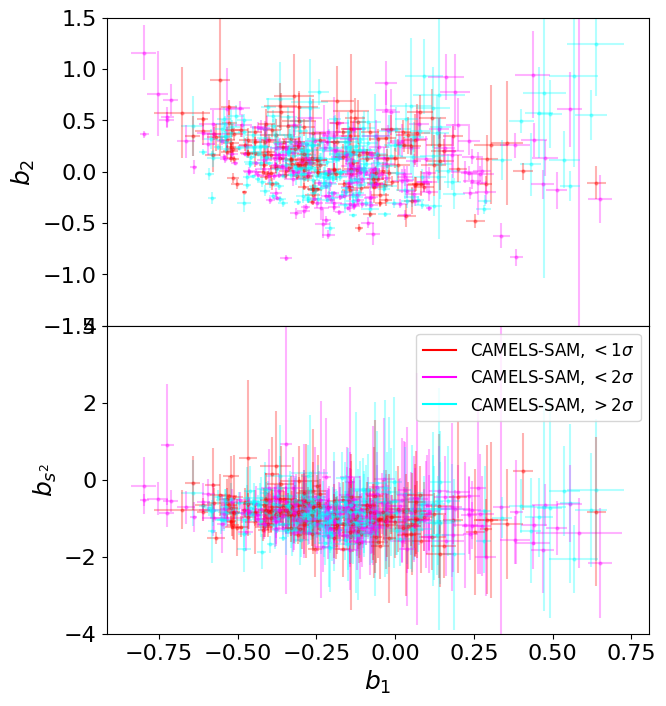

In [116]:
tag0 = '_wsigma0'
idx_tag0 = tags_pbpfit.index(tag0)

nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(7, 4*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

bp_arr = []
Asn_arr = []


pbp_arr_tag0 = pbp_arrs[idx_tag0]
print(pbp_arr_tag0.shape)
bb_b1 = bias_param_names.index('b1')

for i, idx_sam in enumerate(idxs_sam):

    for ib, bp_name in enumerate(bias_param_names_nob1):
        
        bb = bias_param_names.index(bp_name)
        
        bval = np.array(pbp_arr_tag0[i,bb])        
        axarr[ib].errorbar(pbp_arr_tag0[i,bb_b1], bval, 
                            yerr=pbp_cov_arrs[idx_tag0][i,bb], 
                            xerr=pbp_cov_arrs[idx_tag0][i,bb_b1],
                            marker='o', markersize=2, color=colors[i], 
                            ls='None', alpha=0.3)

        axarr[ib].set_ylabel(bias_param_labels[bp_name])
    
    
handles, labels = plt.gca().get_legend_handles_labels()
if color_mode=='discrete':
    handles.extend(handles_discrete)
plt.legend(handles=handles, fontsize=12)
#plt.xlim(-2, 1)

axarr[0].set_ylim(-1.5, 1.5)
axarr[1].set_ylim(-4, 4)
#axarr[2].set_ylim(-10, 20)

plt.xlabel(bias_param_labels[bias_param_names[bb_b1]])

if save_figs:
    plt.savefig(f'{plot_dir}/bps{plot_tag}{tag_bpfit}.png')